In [203]:
# Basic important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# libraries consisting statistical tests
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

# libraries consisting time-series forecasting models
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# importing metrics 
from sklearn.metrics import mean_squared_error

# silencing errors
import warnings
warnings.filterwarnings('ignore')


In [83]:
df=pd.read_csv('Walmart.csv')
df.sample(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
5069,36,29-04-2011,340708.78,0,76.10,3.837,214.358097,8.300
3588,26,07-05-2010,1074479.73,0,54.72,2.981,132.106200,8.512
1115,8,13-04-2012,909989.45,0,65.19,3.891,225.062571,5.679
911,7,11-02-2011,559903.13,1,10.24,3.037,191.857288,8.818
4841,34,08-06-2012,999511.29,0,75.35,3.433,130.889677,9.575
95,1,02-12-2011,1584083.95,0,48.91,3.172,218.714733,7.866
5664,40,07-10-2011,1070389.98,0,50.21,3.633,136.472000,4.420
2025,15,16-07-2010,633203.69,0,72.83,2.933,132.566774,8.099
4682,33,17-02-2012,266300.98,0,57.80,3.781,130.454621,7.603
4413,31,15-06-2012,1431003.43,0,81.51,3.393,221.400990,6.891


In [68]:
# checking shape
df.shape

(6435, 8)

In [69]:
# checking for column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [70]:
# checking for basic statistics
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [71]:
# checking for duplicate values
df.duplicated().sum()

0

In [72]:
# checking for null values
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

# Exploratory data analysis

In [73]:
# separating categorical and numerical columns
num_cols=[x for x in df.columns if df[x].dtypes!='object']
print(len(num_cols))
print(num_cols)

7
['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


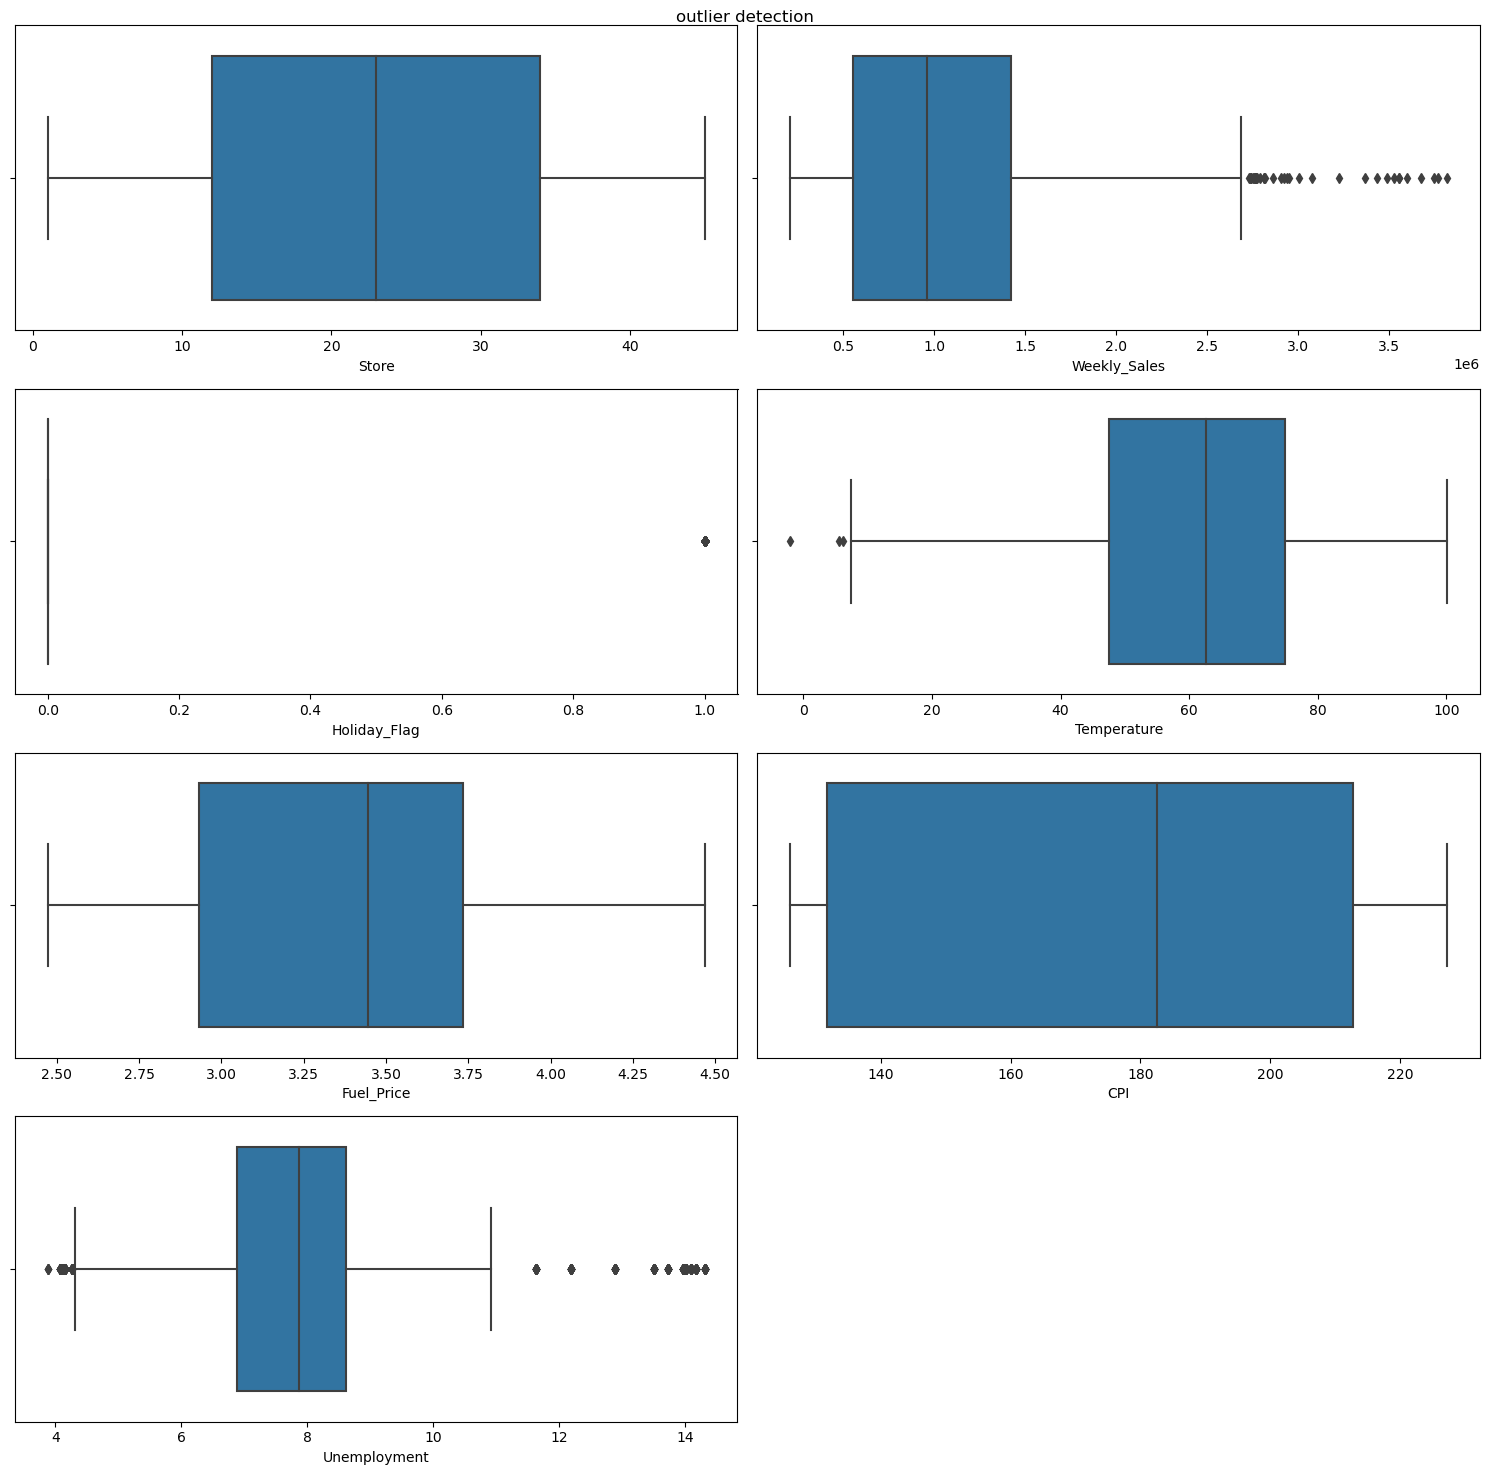

In [74]:
# outlier detection in the numerical columns

fig1=plt.figure(figsize=(15,15))
for i,col in enumerate(num_cols):
    plt.subplot(4,2,i+1)
    sns.boxplot(x=df[col])
    plt.xlabel(col)

plt.suptitle('outlier detection')
plt.tight_layout()
plt.show()

In [75]:
outlier_columns=['Weekly_Sales','Temperature','Unemployment']

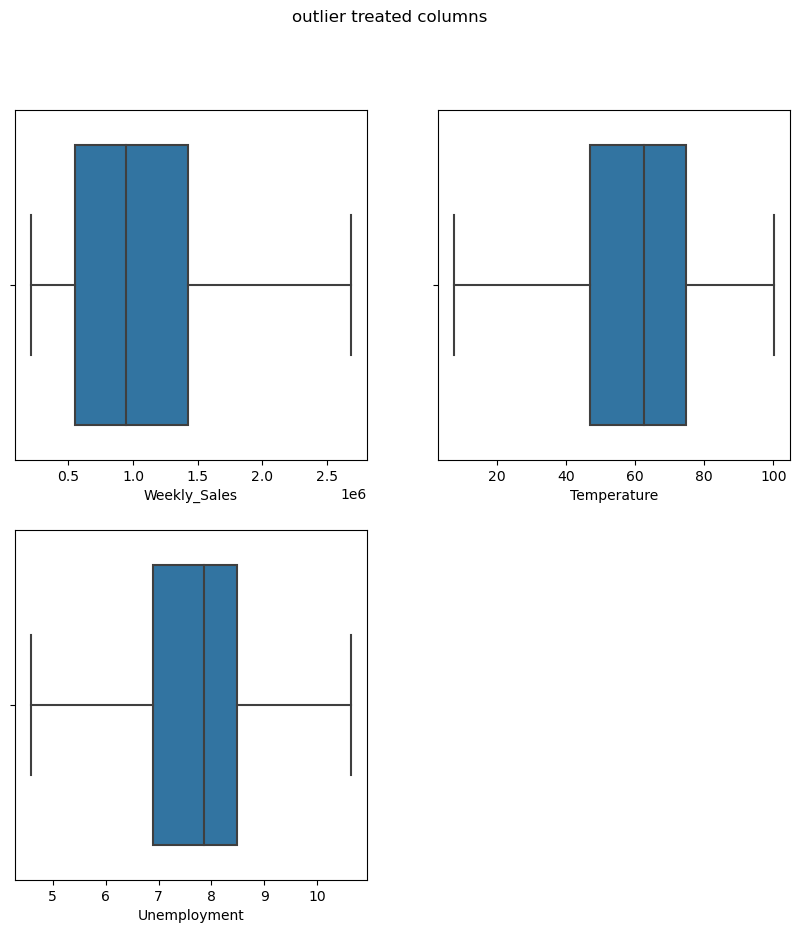

In [77]:
fig2=plt.figure(figsize=(10,10))

#treating columns with outliers 

for i,col in enumerate(outlier_columns):
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-(IQR*1.5)
    upper_bound=Q3+(IQR*1.5)
    df=df[(df[col]>=lower_bound)&(df[col]<=upper_bound)]
    
#visualizing the columns to check the treated columns
    plt.subplot(2,2,i+1)
    sns.boxplot(x=df[col])
    plt.xlabel(col)

plt.suptitle('outlier treated columns')
plt.show()

In [85]:
# converting date to datetime format
# df['Date']=pd.to_datetime(df['Date'], dayfirst=True,format='%d/%m/%Y')
df = pd.read_csv('Walmart.csv', parse_dates=['Date'], dayfirst=True, date_parser=lambda x: pd.to_datetime(x, format='%d-%m-%Y'))

# Visualization

<Axes: xlabel='Holiday_Flag', ylabel='Weekly_Sales'>

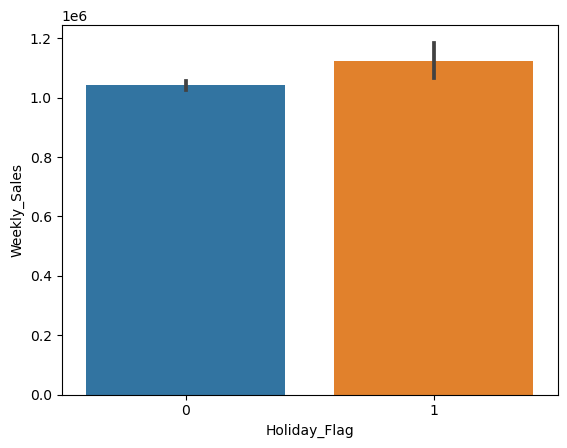

In [86]:
# holiday vs. weekly sales
sns.barplot(x=df.Holiday_Flag,y=df.Weekly_Sales)


The above plot suggests that the sales on holidays are higher in comparison to other days.

### 1. Data distirbution

<Figure size 1600x1000 with 0 Axes>

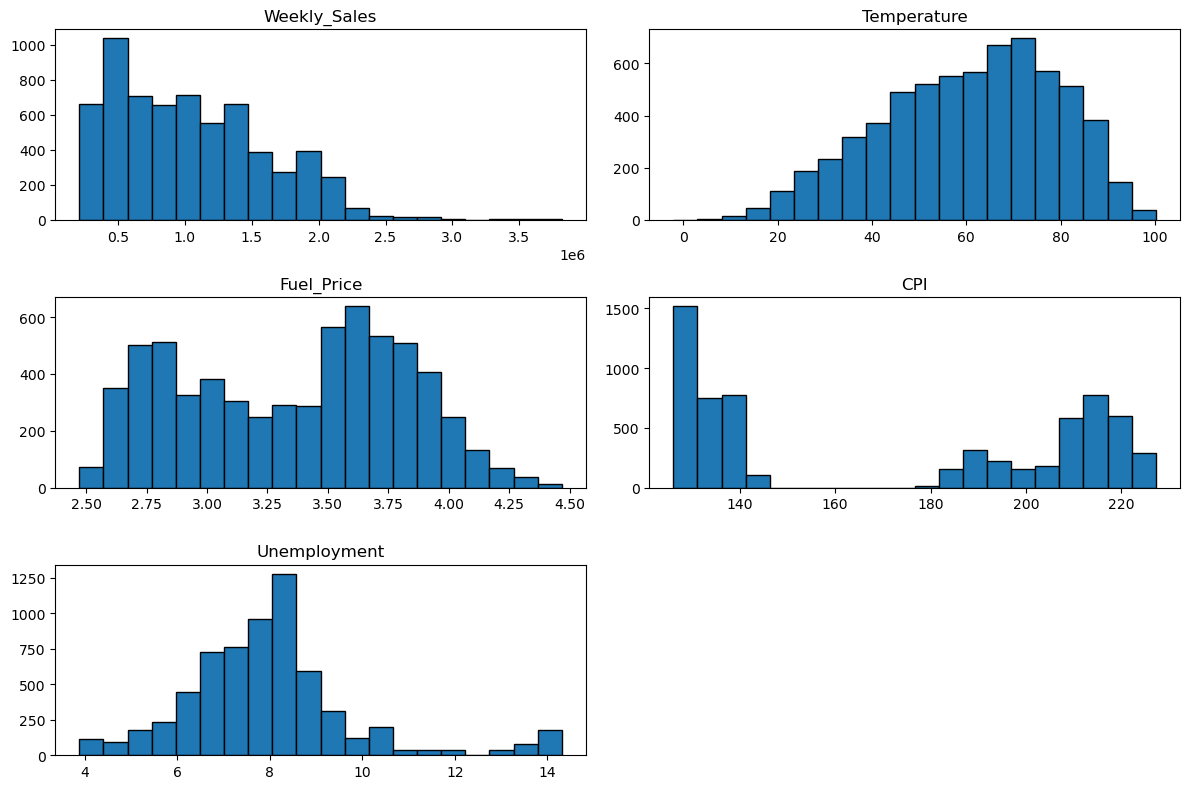

In [87]:
columns=['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

fig4=plt.figure(figsize=(16,10))
df[columns].hist(bins=20,figsize=(12,8),grid=False,edgecolor='black')

plt.tight_layout()
plt.show()

## Scatter plots and correlation analysis

### - Correlation Matrix 

<Axes: >

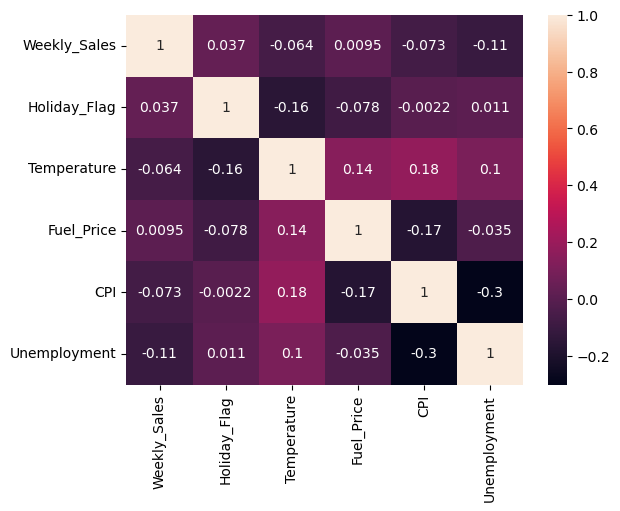

In [88]:
columns1=['Weekly_Sales', 'Holiday_Flag','Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
c1=df[columns1].corr()
sns.heatmap(c1,annot=True)


# alternative method
# c2=np.corrcoef(df[columns1],rowvar=False)
# sns.heatmap(c2,annot=True)

### - Relationship scatter plots 

<Axes: xlabel='Unemployment', ylabel='CPI'>

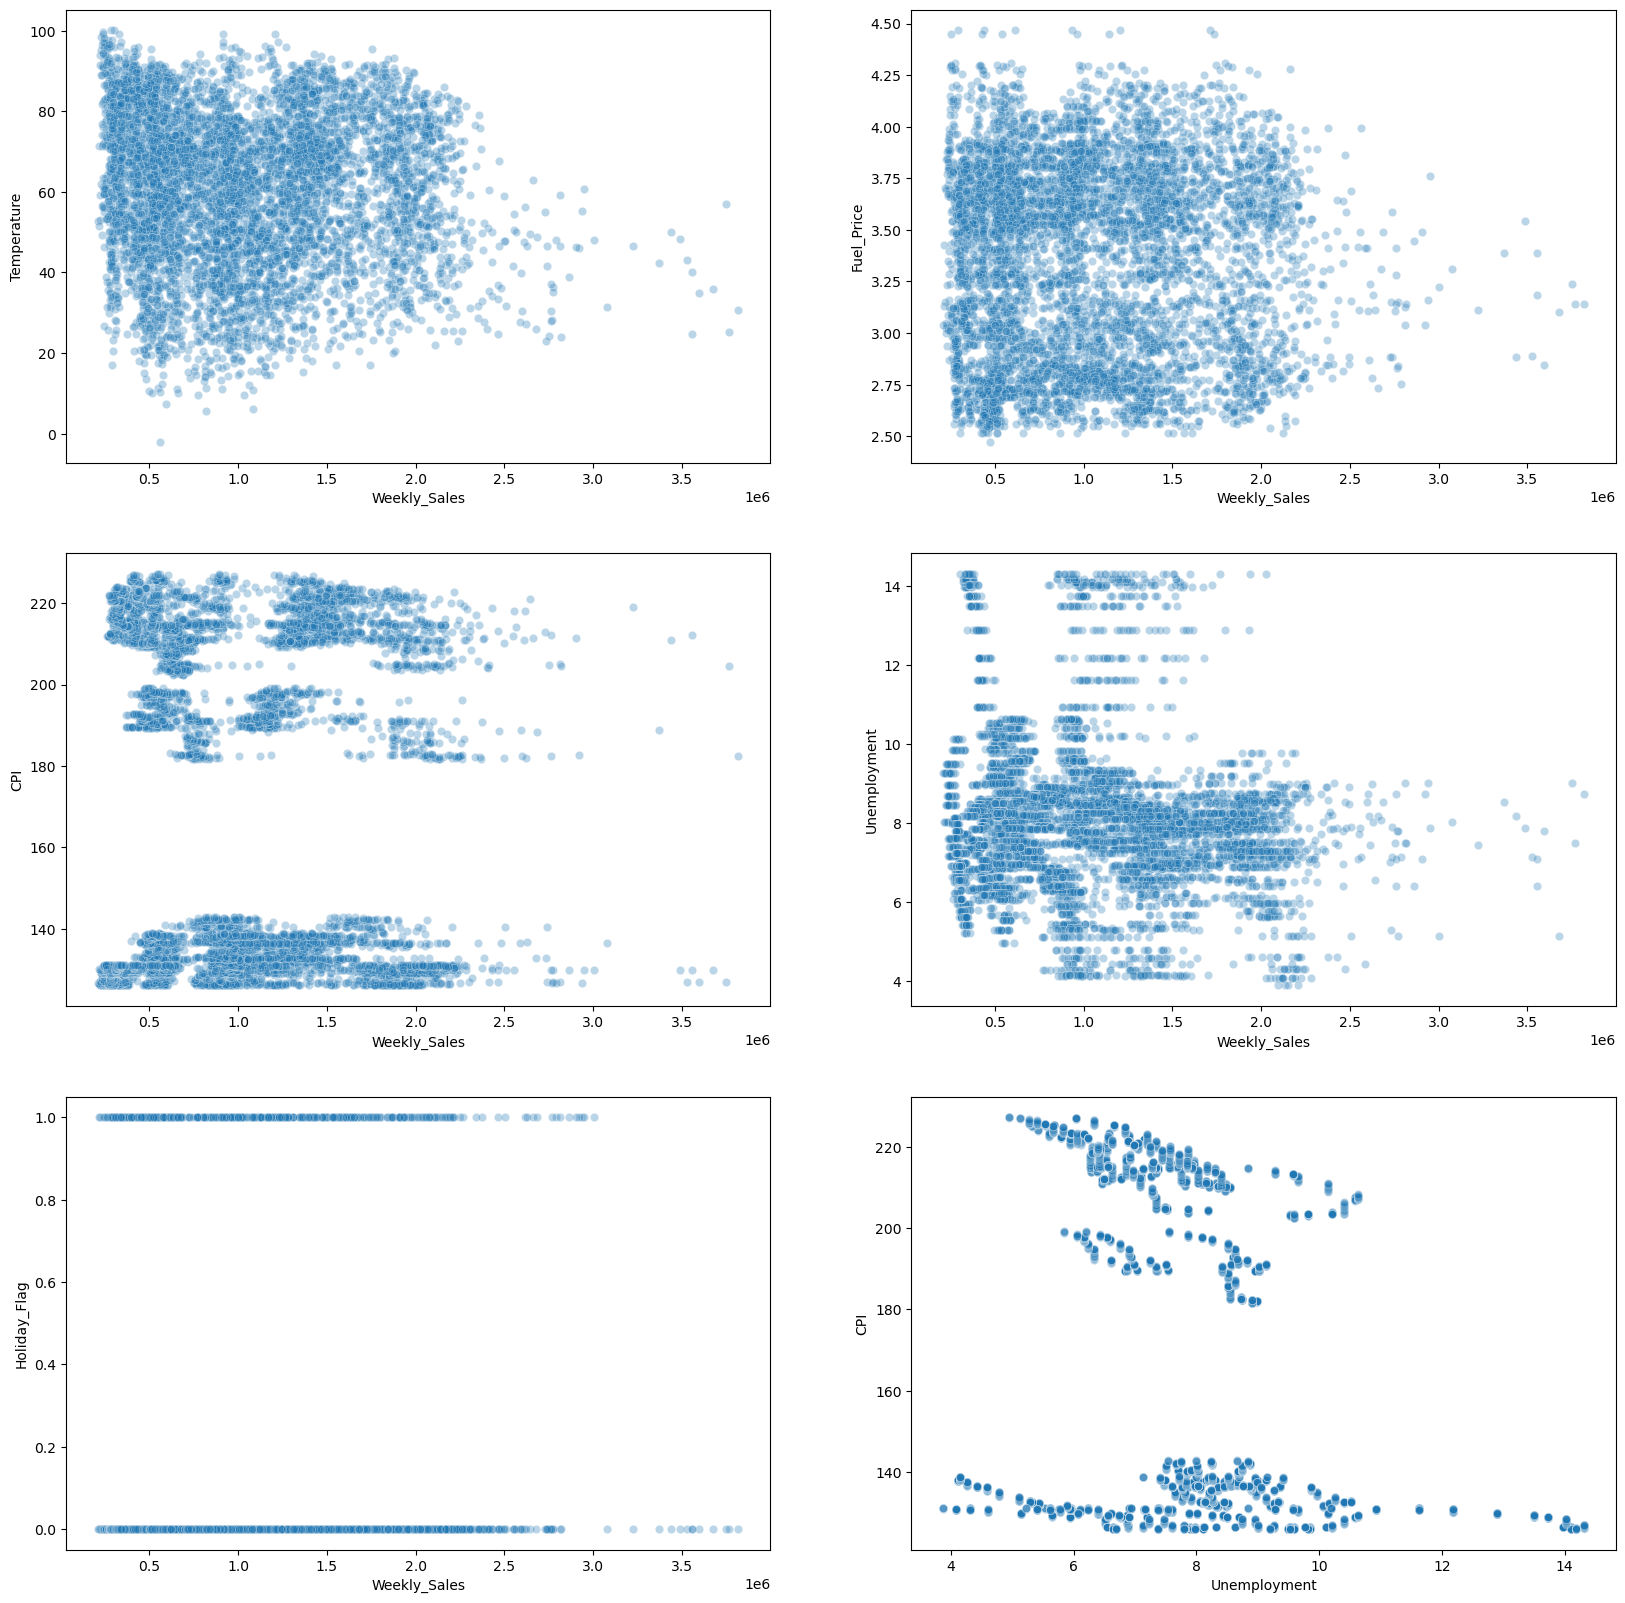

In [89]:
fig5=plt.figure(figsize=(20,20))

# weekly sales vs temperature
plt.subplot(3,2,1)
sns.scatterplot(x=df.Weekly_Sales,y=df.Temperature, alpha=0.3)

# weekly sales vs fuel_price
plt.subplot(3,2,2)
sns.scatterplot(x=df.Weekly_Sales,y=df.Fuel_Price, alpha=0.3)


# weekly sales vs CPI
plt.subplot(3,2,3)
sns.scatterplot(x=df.Weekly_Sales,y=df.CPI, alpha=0.3)

# weekly sales vs Unemployment
plt.subplot(3,2,4)
sns.scatterplot(x=df.Weekly_Sales,y=df.Unemployment, alpha=0.3)

# weekly sales vs Holiday flags
plt.subplot(3,2,5)
sns.scatterplot(x=df.Weekly_Sales,y=df.Holiday_Flag, alpha=0.3)

# unemployment vs CPI
plt.subplot(3,2,6)
sns.scatterplot(x=df.Unemployment,y=df.CPI, alpha=0.3)

By examining the correlation heatmap and scatter-plots above the following inferences can be made:
    
###  Negative correlations:

1. Weekly sales and Temperature
2. Weekly sales and CPI 
3. Weekly sales and Unemployment 
4. Unemployment and CPI

We can conclude that weekly sales is negatively affected by Unemployment, Temperature and CPI, which indicates that the financial and environmental conditions inversely affect the consumer behaviour. 
Furthermore, there is also a negative relationship between Unemployment and fuel price with CPI, which is congruent with the faact that as unemploment rises, the consumer's spending capacity decreases thus leading to a poor CPI score. 

### Positive correlations:    
1. Weekly sales vs Holiday flags
2. Weekly sales vs fuel_price
3. Temperature and unemployment

A positive correlation of weekly sales and holiday flags suggests that a consumer tends to spend more on holidays, key contributors of which could be attributes like promotional offers and commodification of holidays, which in turn justifies the positive relationship between weekly sales and fuel prices, because of higher consumer traffic.
A rise in temperature (which leads to a decrease in weekly sales) tends to be associated with higher rates of unemployment.

### Checking for yearly and monthly trends of weekly sales

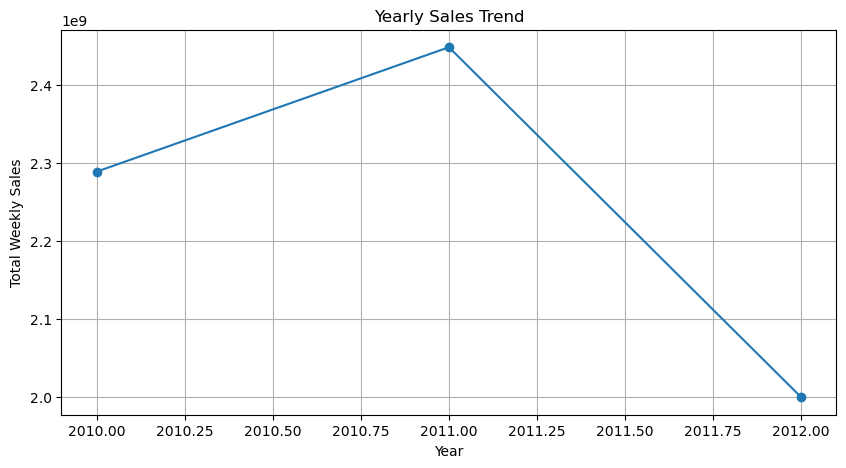

In [90]:
plt.figure(figsize=(10,5))
df['year']=df.Date.dt.year
yearly_sales=df.groupby('year')['Weekly_Sales'].sum()

# visualize it

plt.plot(yearly_sales.index,yearly_sales.values, marker='o', linestyle='-')
plt.title('Yearly Sales Trend')
plt.xlabel('Year')
plt.ylabel('Total Weekly Sales')
plt.grid(True)

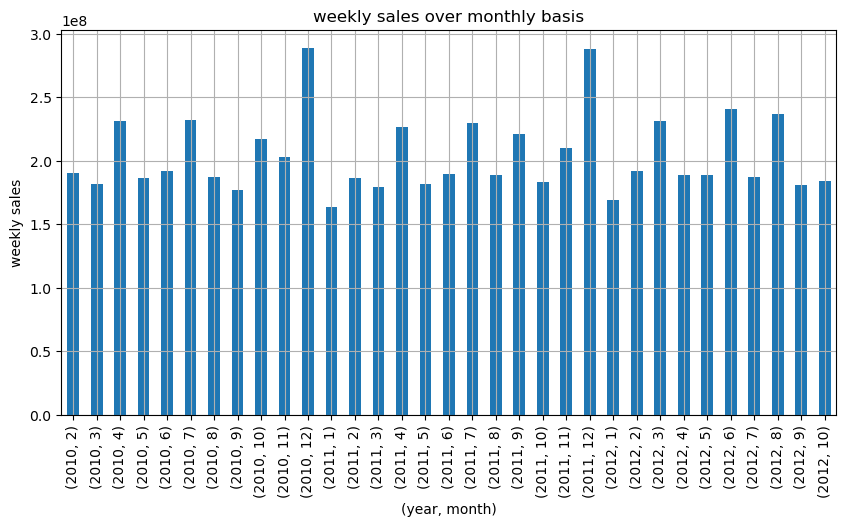

In [91]:
plt.figure(figsize=(10,5))
df['month']=df.Date.dt.month
monthly_sales=df.groupby(['year','month'])['Weekly_Sales'].sum()

monthly_sales.plot(kind='bar')
plt.xlabel('(year, month)')
plt.ylabel('weekly sales')
plt.title('weekly sales over monthly basis')
plt.grid(True)

### Checking if there's a difference in weekly sales during holidays vs. non-holidays.

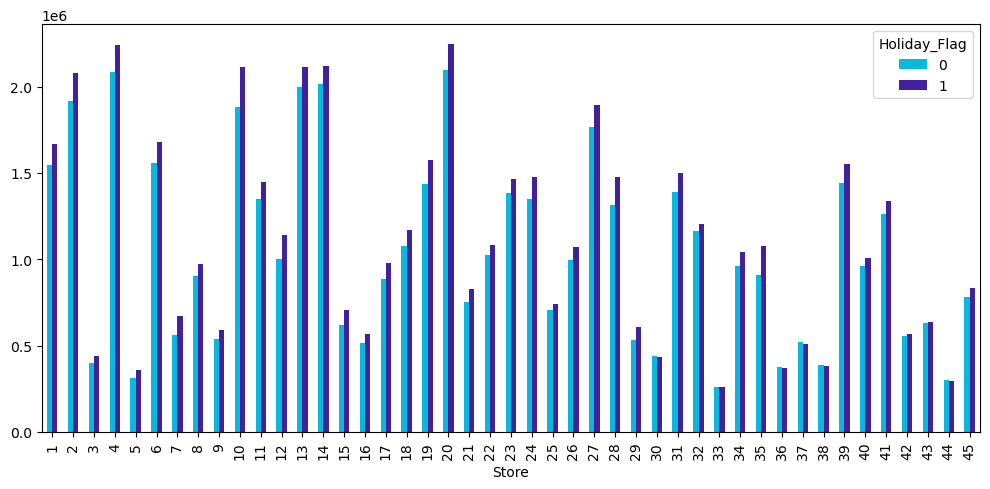

In [93]:
#  checking for differences in weekly sales during holidays vs. non-holidays
weekly_sales_wrt_holidays=df.groupby(['Store','Holiday_Flag'])['Weekly_Sales'].mean().unstack()
weekly_sales_wrt_holidays.plot(kind='bar', color=['#09b8db', '#41219c'], figsize=(10,5))

plt.tight_layout()

# Data analysis

### a. Are the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?

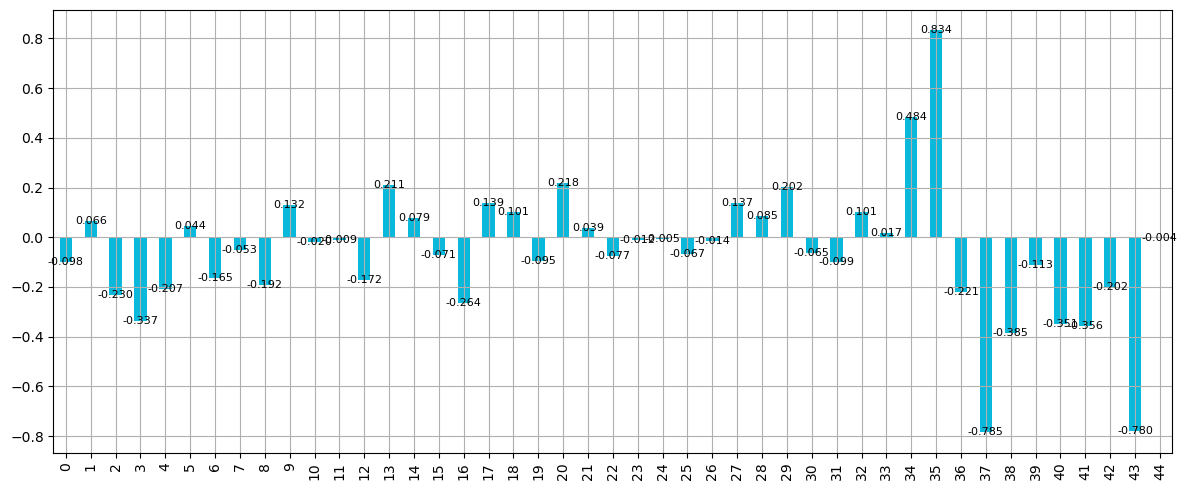

In [129]:
storewise_analysis=df.groupby('Store')[['Weekly_Sales','Unemployment']].corr().iloc[0::2,1].reset_index()
storewise_analysis=storewise_analysis.drop('level_1',axis=1)
storewise_analysis.columns=['Store','Correlation']
ax=storewise_analysis.Correlation.plot(kind='bar',figsize=(12,5),color='#09b8db')

# Annotating the bars with their values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 0), textcoords='offset points')

plt.tight_layout()
plt.grid(True)

### b. If the weekly sales show a seasonal trend, when and what could be the reason?

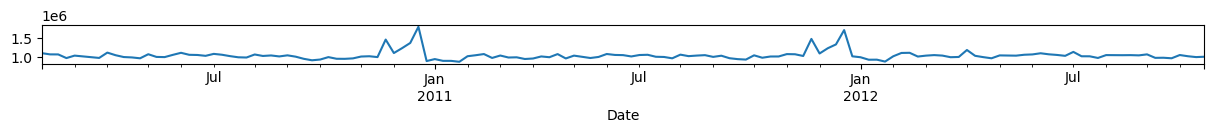

In [205]:
# importing library to extract seasonality, trend and residue
import statsmodels.tsa as sm

# time series
df['week']=df.Date.dt.isocalendar().week

original=df.groupby('Date')['Weekly_Sales'].mean()
original.plot(kind='line',figsize=(15,0.5))

# decomposing the original time series into weekly sales.
decomposition=sm.seasonal.seasonal_decompose(original,model='additive',period=7)
seasonality=decomposition.seasonal
trend=decomposition.trend
residue=decomposition.resid

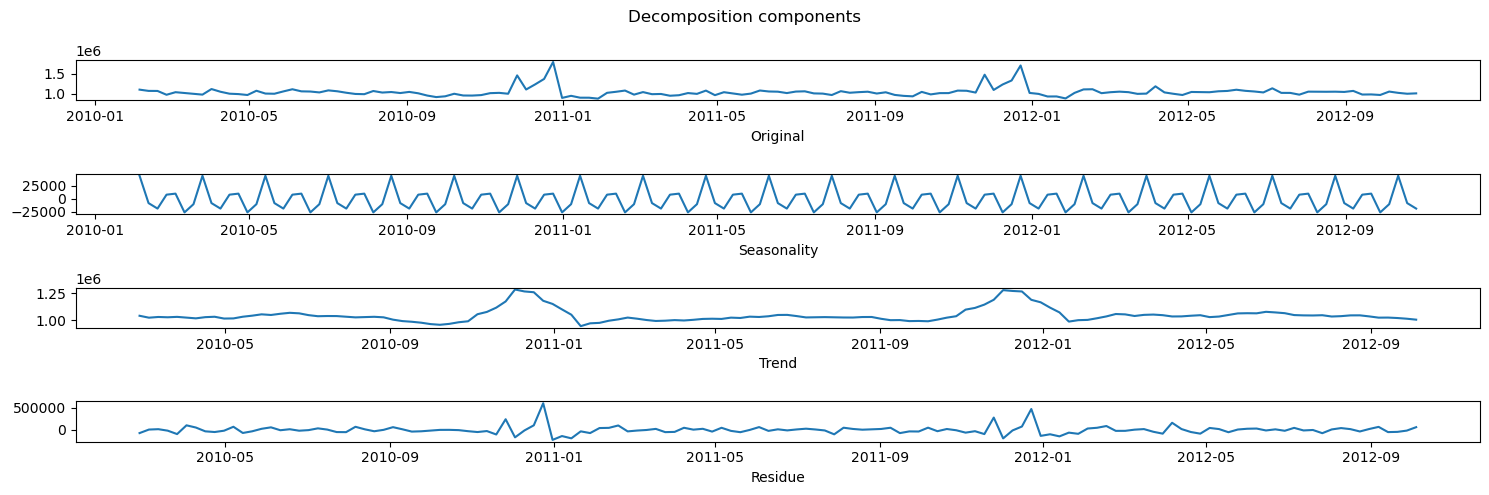

In [206]:
plt.figure(figsize=(15,5))

plt.subplot(4,1,1)
plt.plot(original, label='Original')
plt.xlabel('Original')

plt.subplot(4,1,2)
plt.plot(seasonality, label='Seasonality')
plt.xlabel('Seasonality')

plt.subplot(4,1,3)
plt.plot(trend, label='Trend')
plt.xlabel('Trend')

plt.subplot(4,1,4)
plt.plot(residue, label='Residue')
plt.xlabel('Residue')

plt.suptitle('Decomposition components')
plt.tight_layout()

In [207]:
# Trend Component Analysis
trend_slope = (decomposition.trend.iloc[-1] - decomposition.trend.iloc[0]) / len(decomposition.trend)
print(f'Trend Slope: {trend_slope}')

# Seasonal Component Analysis
seasonal_amplitude = (decomposition.seasonal.max() - decomposition.seasonal.min()) / 2
print(f'Seasonal Amplitude: {seasonal_amplitude}')

# Residual Component Analysis
residual_autocorrelation = decomposition.resid.autocorr()
print(f'Residual Autocorrelation at Lag 1: {residual_autocorrelation}')

Trend Slope: nan
Seasonal Amplitude: 35380.68768863827
Residual Autocorrelation at Lag 1: -0.12224625487571528


In [208]:
stationarity_test=kpss(original)

# Extract and print the test statistic and p-value
test_statistic, p_value, lags, critical_values = stationarity_test[0], stationarity_test[1], stationarity_test[2], stationarity_test[3]

print(f"KPSS Test Statistic: {test_statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Interpret the results
if p_value < 0.05:
    print("The data is likely not stationary around a deterministic trend (reject H0).")
else:
    print("The data is likely stationary around a deterministic trend (fail to reject H0).")

KPSS Test Statistic: 0.04889162911077951
P-Value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The data is likely stationary around a deterministic trend (fail to reject H0).


The above test and visual inspection of the decomposed components suggests the presence of a seasonal trend, around December, which is likely due to holidays and the sales associated with them. 

### c. Does temperature affect the weekly sales in any manner?


In [107]:
np.corrcoef(df.Temperature,df.Weekly_Sales)

array([[ 1.        , -0.06381001],
       [-0.06381001,  1.        ]])

Negative correlation

### d. How is the Consumer Price index affecting the weekly sales of various stores?

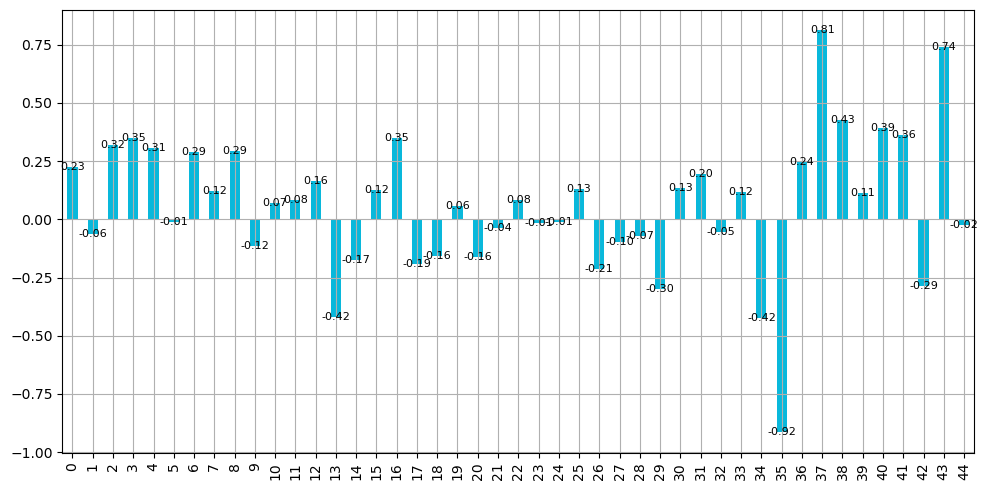

In [128]:
cpi_wrt_ws=df.groupby('Store')[['CPI','Weekly_Sales']].corr().iloc[0::2,1].reset_index()
cpi_wrt_ws=cpi_wrt_ws.drop('level_1',axis=1)
cpi_wrt_ws.columns=['Store','CPI_wrt_WS']
ax=cpi_wrt_ws.CPI_wrt_WS.plot(kind='bar',figsize=(10,5),color='#09b8db')

# annotation
for p in ax.patches:
    plt.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 0), textcoords='offset points')

plt.tight_layout()
plt.grid(True)

### e. Top performing stores according to the historical data.


<Axes: xlabel='Store'>

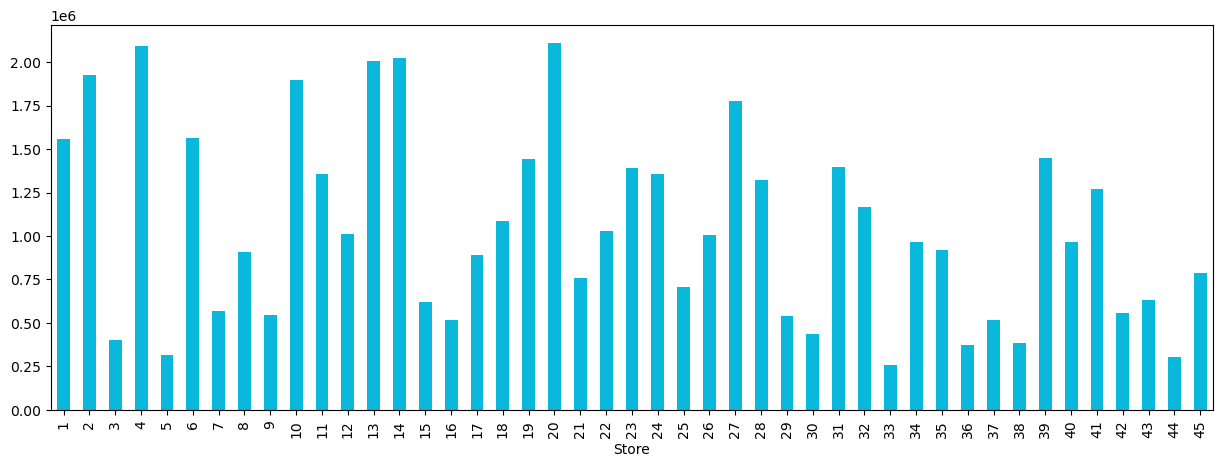

In [165]:
# average weekly sales storewise
avg_weekly_sales_storewise=df.groupby('Store')['Weekly_Sales'].mean()
avg_weekly_sales_storewise.plot(kind='bar',figsize=(15,5),color='#09b8db')

In [166]:
ranked_stores=avg_weekly_sales_storewise.sort_values(ascending=False).reset_index()
ranked_stores.index +=1
ranked_stores

,Store,Weekly_Sales
1,20,2.107677e+06
2,4,2.094713e+06
3,14,2.020978e+06
4,13,2.003620e+06
5,2,1.925751e+06
6,10,1.899425e+06
7,27,1.775216e+06
8,6,1.564728e+06
9,1,1.555264e+06
10,39,1.450668e+06


### f. The worst performing store, and how significant is the difference between the highest and lowest performing stores.

In [155]:
print('The worst performing store is:', ranked_stores.iloc[-1]['Store'])

The worst performing store is: 33.0


In [162]:
difference_highest_lowest_stores=(ranked_stores.iloc[0]['Weekly_Sales'])-(ranked_stores.iloc[-1]['Weekly_Sales'])
print('The difference between the highest and lowest performing stores is: ',(ranked_stores.iloc[0]['Weekly_Sales'])-(ranked_stores.iloc[-1]['Weekly_Sales']))

The difference between the highest and lowest performing stores is:  1847815.1783216782


## 2. Use predictive modeling techniques to forecast the sales for each store for the next 12 weeks.

In [167]:
# goruping sales by stores for forecasting sales storewise

sales_by_store=df.groupby(['Store','Date'])['Weekly_Sales'].sum()
store1_sales=sales_by_store[1]
store1_sales

Date
2010-02-05    1643690.90
2010-02-12    1641957.44
2010-02-19    1611968.17
2010-02-26    1409727.59
2010-03-05    1554806.68
                 ...    
2012-09-28    1437059.26
2012-10-05    1670785.97
2012-10-12    1573072.81
2012-10-19    1508068.77
2012-10-26    1493659.74
Name: Weekly_Sales, Length: 143, dtype: float64

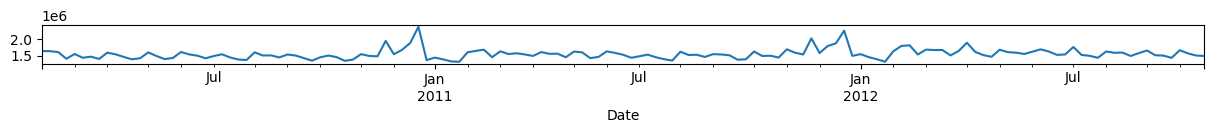

In [168]:
# importing library to extract seasonality, trend and residue
import statsmodels.tsa as sm

# time series
original=store1_sales
original.plot(kind='line',figsize=(15,0.5))

# decomposing the original time series into weekly sales.
decomposition=sm.seasonal.seasonal_decompose(original,model='multiplicative',period=7)
seasonality=decomposition.seasonal
trend=decomposition.trend
residue=decomposition.resid

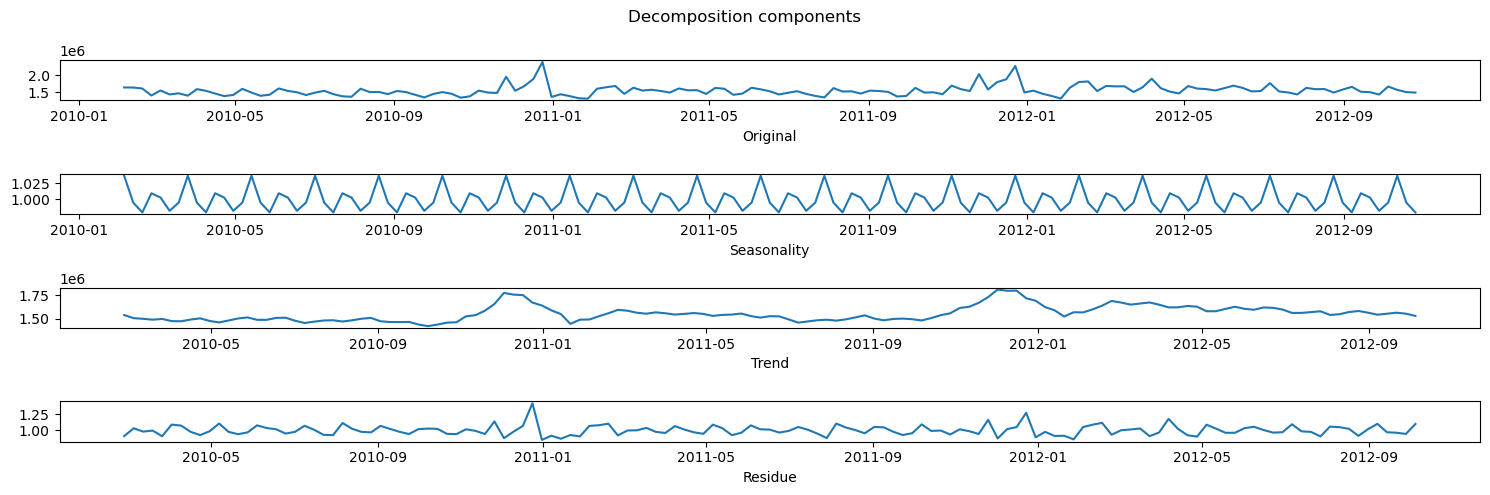

In [169]:
plt.figure(figsize=(15,5))

plt.subplot(4,1,1)
plt.plot(original, label='Original')
plt.xlabel('Original')

plt.subplot(4,1,2)
plt.plot(seasonality, label='Seasonality')
plt.xlabel('Seasonality')

plt.subplot(4,1,3)
plt.plot(trend, label='Trend')
plt.xlabel('Trend')

plt.subplot(4,1,4)
plt.plot(residue, label='Residue')
plt.xlabel('Residue')

plt.suptitle('Decomposition components')
plt.tight_layout()

The above plots on visual inspection suggests a weak seasonal pattern, which means that the data will have to checked and then treated for seasonality and trend. 

In [174]:
# checking for data stationarity

# test #1 Augmented Dickey Fuller Test


result=adfuller(store1_sales)

pval=result[1]
pval

print('''H0: The data has a unit root (non-stationary).
H1: The data does not have a unit root (stationary).''')

if (pval<0.05):
    print(f'P value = {pval}, thus rejecting null hypothesis, the time series is stationary.')
else:
    print(f'P value = {pval}, thus failing to reject null hypothesis, the time series is not stationary.')

H0: The data has a unit root (non-stationary).
H1: The data does not have a unit root (stationary).
P value = 1.3877788330759434e-05, thus rejecting null hypothesis, the time series is stationary


In [175]:
# but the visual inspection shows a weak trend and seasonality, which warrants cross checking for stationarity.

# testing for stationarity, and checking for the presence of trend

# performing kpss test
result=kpss(store1_sales)

# Extract and print the test statistic and p-value
test_statistic, p_value, lags, critical_values = result[0], result[1], result[2], result[3]

print(f"KPSS Test Statistic: {test_statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Interpret the results
if p_value < 0.05:
    print("The data is likely not stationary around a deterministic trend (reject H0).")
else:
    print("The data is likely stationary around a deterministic trend (fail to reject H0).")


KPSS Test Statistic: 0.4758942566191388
P-Value: 0.047095888148842614
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The data is likely not stationary around a deterministic trend (reject H0).


In [176]:
# treating data for stationarity and trend

### Differencing the time series
to remove trends.

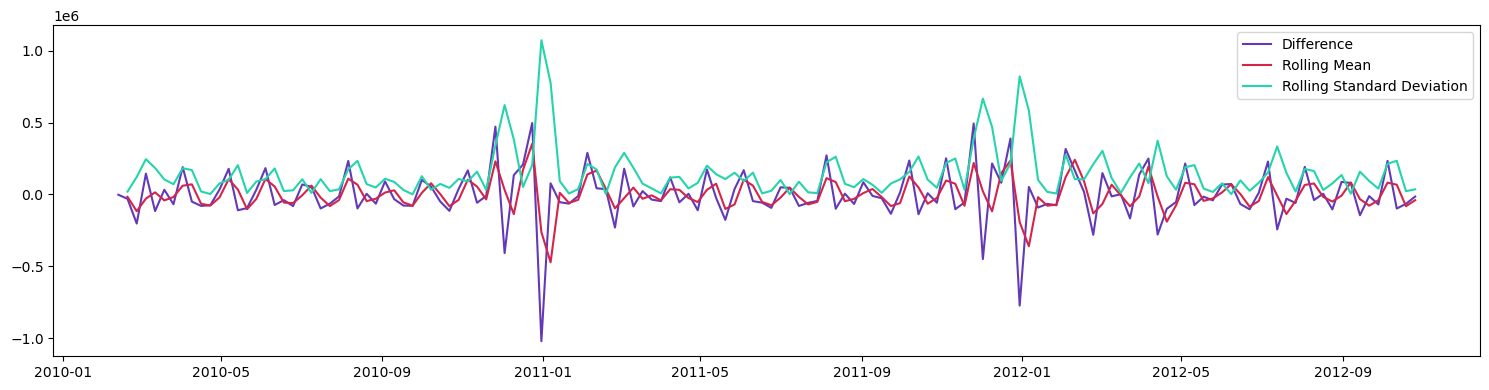

In [178]:
difference_sales= store1_sales.diff().dropna() #creating difference values

# taking mean and std of differenced data
diff_roll_mean = difference_sales.rolling(window=2, center=False).mean()
diff_roll_std = difference_sales.rolling(window=2, center=False).std()

# plotting these values
plt.figure(figsize=(15, 4))
plt.plot(difference_sales, color='#6339b8',label='Difference')
plt.plot(diff_roll_mean, color='#d4244a', label='Rolling Mean')
plt.plot(diff_roll_std, color='#24d4ab', label='Rolling Standard Deviation')
plt.legend()
plt.tight_layout()


### Shift
required to build autoregressive models, capture seasonality, modeling trends.

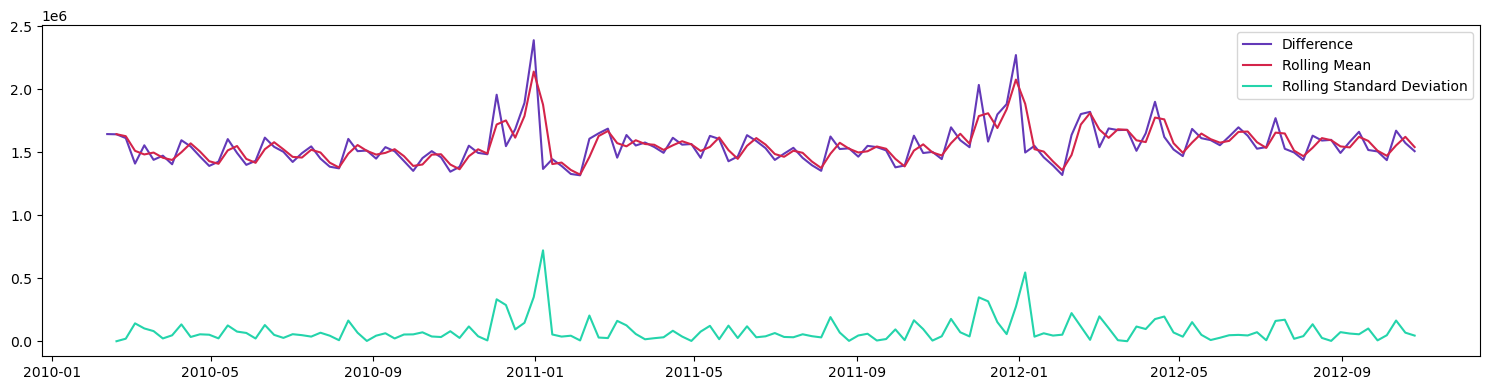

In [179]:
lag_sales = store1_sales.shift().dropna() #shifting the data 

# calculating mean and std
lag_roll_mean = lag_sales.rolling(window=2, center=False).mean() 
lag_roll_std = lag_sales.rolling(window=2, center=False).std()

# visualizing the data
plt.subplots(figsize=(15, 4))
plt.plot(lag_sales, color='#6339b8',label='Difference')
plt.plot(lag_roll_mean, color='#d4244a', label='Rolling Mean')
plt.plot(lag_roll_std, color='#24d4ab', label='Rolling Standard Deviation')
plt.legend()
plt.tight_layout()

### Log
For stabalizing variance and normalization purposes. 

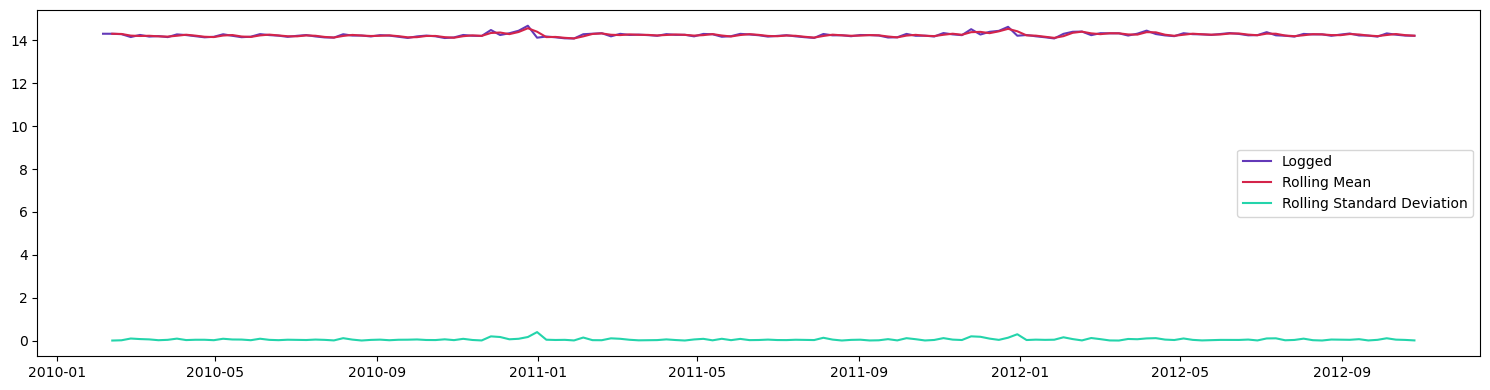

In [180]:
logged_sales = np.log1p(store1_sales).dropna() #taking log of data

# taking mean and standard deviation of the data
log_roll_mean = logged_sales.rolling(window=2, center=False).mean()
log_roll_std = logged_sales.rolling(window=2, center=False).std()

# visualizing the data
plt.figure(figsize=(15, 4))
plt.plot(logged_sales, color='#6339b8',label='Logged')
plt.plot(log_roll_mean, color='#d4244a', label='Rolling Mean')
plt.plot(log_roll_std, color='#24d4ab', label='Rolling Standard Deviation')
plt.legend()
plt.tight_layout()


In [181]:
# train test split

threshold=int(len(difference_sales)*0.7)
train=difference_sales.iloc[:threshold]
test=difference_sales.iloc[threshold:]

### Fitting various forecasting models on the time series

In [183]:
# auto_arima to determine order for models
model_auto_arima = auto_arima(train, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False,m=7)
model_auto_arima.fit(difference_sales)

 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=2554.282, Time=0.09 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=2531.612, Time=0.07 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=2533.391, Time=0.14 sec
 ARIMA(0,0,0)(0,1,3)[7] intercept   : AIC=2534.962, Time=0.32 sec
 ARIMA(0,0,0)(0,1,4)[7] intercept   : AIC=2535.411, Time=0.39 sec
 ARIMA(0,0,0)(0,1,5)[7] intercept   : AIC=2537.262, Time=0.73 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=2539.658, Time=0.06 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=2533.361, Time=0.13 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(1,1,3)[7] intercept   : AIC=2534.417, Time=0.49 sec
 ARIMA(0,0,0)(1,1,4)[7] intercept   : AIC=2537.224, Time=0.65 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=2540.407, Time=0.11 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=2535.245, Time=0.16 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : AIC=2534.601, Time=0.30 sec
 ARIMA(0,0,0)(2,1,3)[7] intercept   : AIC=2537.359, Time=0.52 sec
 ARIMA(0,0,0)(3

ARIMA(maxiter=200, order=(4, 0, 0), scoring_args={},
      seasonal_order=(0, 1, 1, 7), suppress_warnings=True)

## Fitting time-series on the best model parameters

<Axes: >

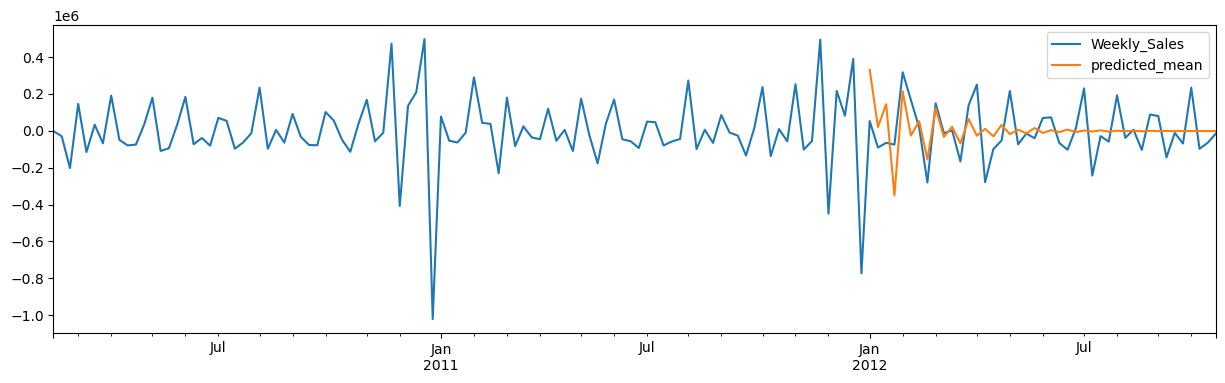

In [194]:
# ARIMA model

model1=ARIMA(train, order=(4, 0, 0),seasonal_order=(0, 0, 0,7)).fit()
predict1=model1.predict(start=len(train),end=(len(train)+len(test)-1))
pd.concat([difference_sales,predict],axis=1).plot(figsize=(15,4))

<Axes: >

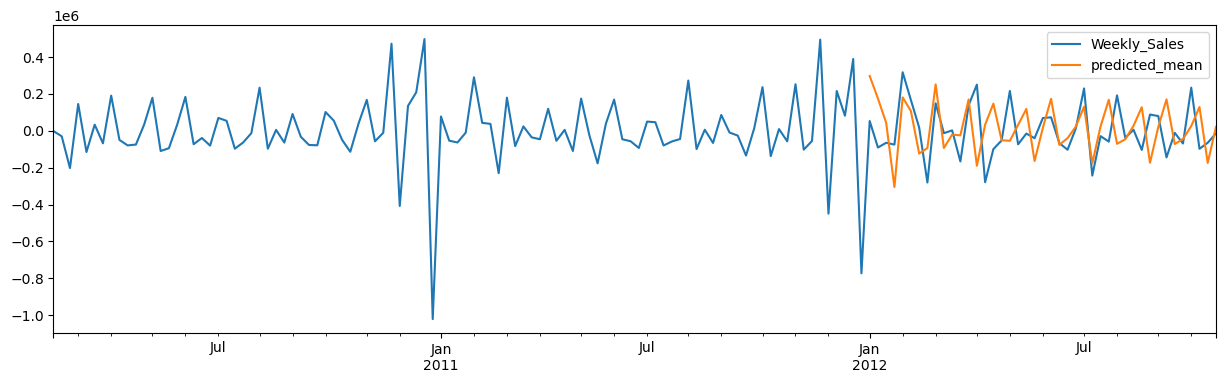

In [191]:
# SARIMAX model

model2=SARIMAX(train,order=(4, 0, 0),seasonal_order=(0, 1, 1,7)).fit()

predict2=model2.predict(start=len(train),end=len(train)+len(test)-1)

pd.concat([difference_sales,predict2],axis=1).plot(figsize=(15,4))

<Axes: >

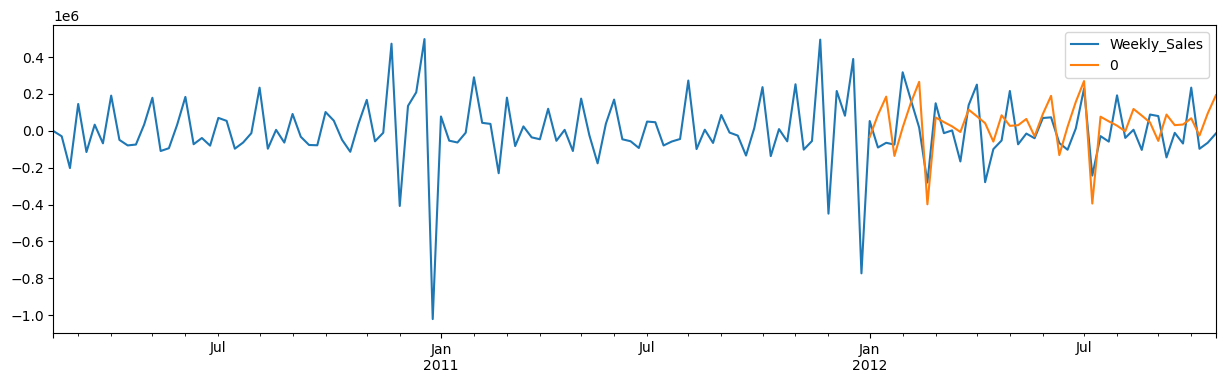

In [192]:
# Exponential Smoothening model

model3=ExponentialSmoothing(train, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
predict3= model3.forecast(len(test))# Predict the test data

pd.concat([difference_sales,predict3],axis=1).plot(figsize=(15,4))

In [210]:
# Calculating mean square error for each model
print('Costs for the respective models are as following: ')

# for ARIMA
print(f'ARIMA model: {np.sqrt(mean_squared_error(test,predict1))}')

# for SARIMAX
print(f'For SARIMAX: {np.sqrt(mean_squared_error(test,predict2))}')

# for Expoential smoothening
print(f'For Exponential Smoothening: {np.sqrt(mean_squared_error(test,predict3))}')

Costs for the respective models are as following: 
ARIMA model: 138387.1884654813
For SARIMAX: 171838.3670517064
For Exponential Smoothening: 142759.12815308373


#### Even though the mean square error for ARIMA model is lower than Exponential smoothening, it is evidient from visual inspection that exponential smoothening forecasts the data better than ARIMA.  

<Axes: >

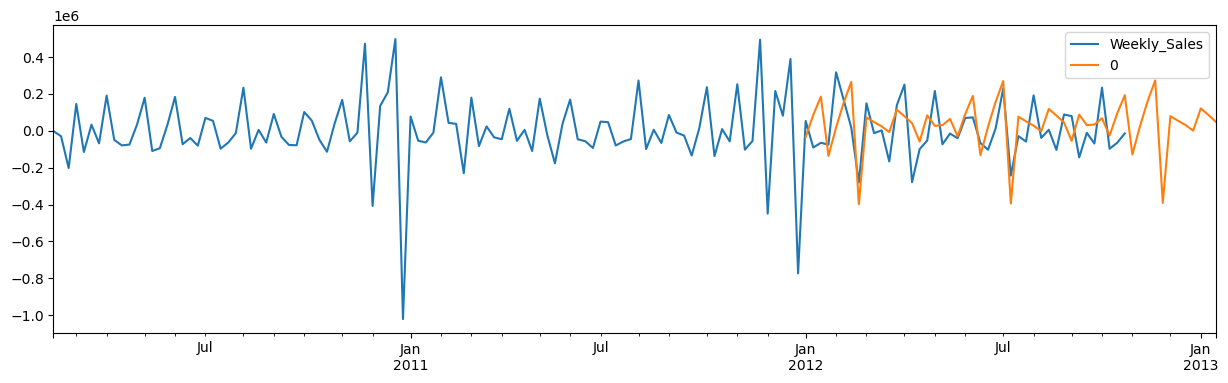

In [217]:
# using Exponential smoothening (model3) for forecasting the sales for store 1 for the next 12 weeks. 

forecast_for_next_12_weeks=model3.forecast(len(test)+12)
pd.concat([difference_sales,forecast_for_next_12_weeks],axis=1).plot(figsize=(15,4))